# Anime GAN

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from time import time

In [2]:
path_dataset = './Datasets/Anime/'
image_dataset = './Datasets/Anime/Anime_Faces/'

In [3]:
images = os.listdir(image_dataset)

Text(0.5, 1.0, '23781_2008.jpg')

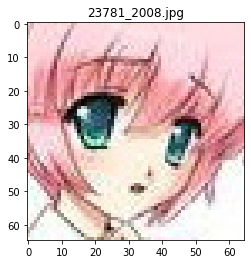

In [4]:
name1 = images[np.random.randint(0,len(images))]
path1 = image_dataset + name1
plt.imshow(Image.open(path1))
plt.title(name1)

In [5]:
total_images = len(images)
batch_size = 32

In [6]:
data_gen = keras.preprocessing.image.ImageDataGenerator()

In [7]:
faces = data_gen.flow_from_directory(path_dataset, target_size = (50,50), class_mode=None, batch_size = batch_size)

Found 63565 images belonging to 1 classes.


In [8]:
faces.image_shape

(50, 50, 3)

In [13]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*64, input_shape = [codings_size]),
    keras.layers.Reshape([7,7,64]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size =5, strides = 2, padding = 'same',
                       activation = keras.layers.LeakyReLU(0.2),
                       input_shape = [56,56,3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides = 2, padding='same',
                       activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [14]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

In [15]:
noise = tf.random.normal(shape=[batch_size, codings_size])

In [16]:
generator(noise)

InternalError: cuDNN launch failure : input shape ([32,7,7,64]) [Op:FusedBatchNormV3]

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        start = time()
        i = 0
        while i < total_images//batch_size:
            X_batch = dataset.next()
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size, 3])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size, 3])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            i+=1
        print(f"Duration {time() - start} s")

In [ ]:
train_gan(gan, faces, batch_size, coding_size)